In [1]:
! pip install -q tensorflow librosa soundfile numpy matplotlib

In [2]:
import tensorflow as tf
import soundfile as sf
import librosa
import numpy as np 
import matplotlib.pyplot as plt
import IPython.display as ipd
from pathlib import Path

In [3]:
# Constants
N_FFT = 2048
N_FILTERS = 4096
ALPHA = 1e-2  # Content loss weight 
MAX_ITERATIONS = 300

def read_audio_spectrum(filename):
    """Read and process audio file into spectrum"""
    x, fs = librosa.load(filename)
    print(f"Sampling rate: {fs}")
    
    # Compute STFT
    S = librosa.stft(x, n_fft=N_FFT)
    p = np.angle(S)
    
    # Take log of magnitude
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs, p, x

In [4]:
class AudioStyleModel(tf.keras.Model):
    def __init__(self, n_channels, n_filters):
        super(AudioStyleModel, self).__init__()
        
        # Initialize kernel with same approach as original
        std = np.sqrt(2) * np.sqrt(2.0 / ((n_channels + n_filters) * 11))
        kernel_init = tf.random_normal_initializer(stddev=std)
        
        self.conv = tf.keras.layers.Conv2D(
            filters=n_filters,
            kernel_size=(1, 11),
            kernel_initializer=kernel_init,
            padding='valid')
        
        self.relu = tf.keras.layers.ReLU()
        
    def call(self, inputs):
        x = self.conv(inputs)
        return self.relu(x)

def compute_gram_matrix(features):
    """Compute Gram matrix for style features"""
    batch_size, height, width, channels = features.shape
    features = tf.reshape(features, (height * width, channels))
    gram = tf.matmul(features, features, transpose_a=True)
    return gram / tf.cast(height * width, tf.float32)

def compute_loss(model, content_features, style_gram, target):
    """Compute total loss (content + style)"""
    target_features = model(target)
    
    # Content loss
    content_loss = ALPHA * tf.reduce_mean(tf.square(target_features - content_features))
    
    # Style loss
    target_gram = compute_gram_matrix(target_features)
    style_loss = tf.reduce_mean(tf.square(target_gram - style_gram))
    
    # Total loss
    total_loss = content_loss + style_loss
    
    return total_loss, content_loss, style_loss

@tf.function
def train_step(model, optimizer, content_features, style_gram, target):
    """Single optimization step"""
    with tf.GradientTape() as tape:
        loss, content_loss, style_loss = compute_loss(model, content_features, style_gram, target)
    
    gradients = tape.gradient(loss, target)
    optimizer.apply_gradients([(gradients, target)])
    
    return loss, content_loss, style_loss



In [5]:
def audio_style_transfer(content_path, style_path, output_path):
    # Read and process audio files
    content_spectrum, content_fs, content_phase, content_audio = read_audio_spectrum(content_path)
    style_spectrum, style_fs, _, _ = read_audio_spectrum(style_path)
    
    # Adjust style spectrum to match content dimensions
    N_SAMPLES = content_spectrum.shape[1]
    N_CHANNELS = content_spectrum.shape[0]
    style_spectrum = style_spectrum[:N_CHANNELS, :N_SAMPLES]
    
    # Prepare data for model
    content_tf = tf.expand_dims(tf.expand_dims(tf.transpose(content_spectrum), 0), 0)
    style_tf = tf.expand_dims(tf.expand_dims(tf.transpose(style_spectrum), 0), 0)
    
    # Create model
    model = AudioStyleModel(N_CHANNELS, N_FILTERS)
    
    # Compute content and style features
    content_features = model(tf.cast(content_tf, tf.float32))
    style_features = model(tf.cast(style_tf, tf.float32))
    style_gram = compute_gram_matrix(style_features)
    
    # Initialize target variable
    target = tf.Variable(
        tf.random.normal([1, 1, N_SAMPLES, N_CHANNELS]) * 1e-3,
        trainable=True
    )
    
    # Setup optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    # Optimization loop
    for i in range(MAX_ITERATIONS):
        loss, content_loss, style_loss = train_step(
            model, optimizer, content_features, style_gram, target)
        
        if i % 50 == 0:
            print(f'Iteration {i}, '
                  f'Loss: {loss:.4f}, '
                  f'Content Loss: {content_loss:.4f}, '
                  f'Style Loss: {style_loss:.4f}')
    
    # Process result
    result = target.numpy()
    a = np.zeros_like(content_spectrum)
    a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1
    
    # Phase reconstruction
    p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
    for i in range(500):
        S = a * np.exp(1j*p)
        x = librosa.istft(S, n_fft=N_FFT)
        p = np.angle(librosa.stft(x, n_fft=N_FFT))
    
    # Save result
    sf.write(output_path, x, content_fs)
    
    return x, content_fs


In [6]:
# Example usage (in a cell by itself)
if __name__ == "__main__":
    content_path = '../audio/dont.mp3'
    style_path = '../audio/fade.mp3'
    output_path = '../audio/output_styled.wav'

    # Run style transfer
    output_audio, fs = audio_style_transfer(content_path, style_path, output_path)

    # Play the result 
    ipd.Audio(output_audio, rate=fs)

Sampling rate: 22050
Sampling rate: 22050
Iteration 0, Loss: 0.0163, Content Loss: 0.0014, Style Loss: 0.0148
Iteration 50, Loss: 0.0163, Content Loss: 0.0014, Style Loss: 0.0148
Iteration 100, Loss: 0.0162, Content Loss: 0.0014, Style Loss: 0.0148
Iteration 150, Loss: 0.0162, Content Loss: 0.0014, Style Loss: 0.0148
Iteration 200, Loss: 0.0162, Content Loss: 0.0014, Style Loss: 0.0148
Iteration 250, Loss: 0.0162, Content Loss: 0.0014, Style Loss: 0.0148


Sampling rate: 22050
Sampling rate: 22050
Sampling rate: 22050


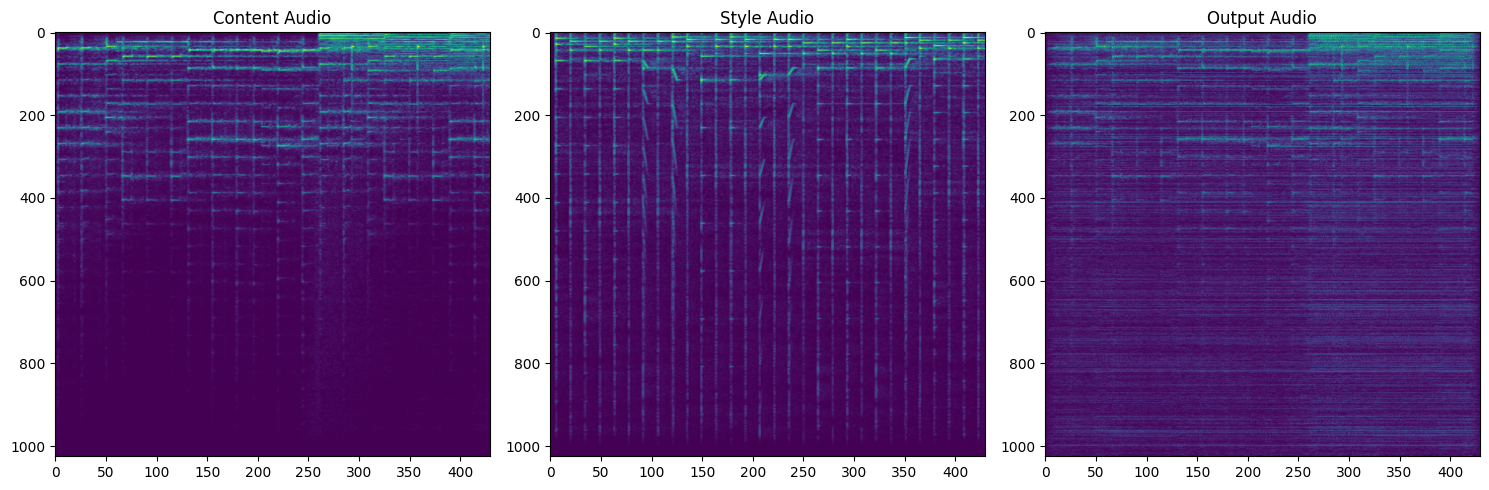

None


In [10]:
# Optional: Plot spectrograms (in a separate cell)
def plot_spectrograms(content_path, style_path, output_path):
    # Load and compute spectrograms
    content_spec, _, _, _ = read_audio_spectrum(content_path)
    style_spec, _, _, _ = read_audio_spectrum(style_path)
    output_spec, _, _, _ = read_audio_spectrum(output_path)
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot spectrograms
    ax1.imshow(content_spec, aspect='auto')
    ax1.set_title('Content Audio')
    
    ax2.imshow(style_spec, aspect='auto')
    ax2.set_title('Style Audio')
    
    ax3.imshow(output_spec, aspect='auto')
    ax3.set_title('Output Audio')
    
    plt.tight_layout()
    print(plt.show())

plot_spectrograms(content_path, style_path, output_path)    
